# Importing libraries

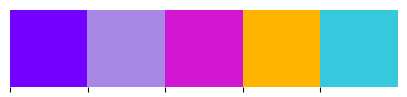

In [1]:
import warnings

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from tqdm import tqdm

init_notebook_mode(connected=True)
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

pd.set_option("display.max_columns", 50)
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category="FutureWarning")
# warnings.filterwarnings("ignore", category="DeprecationWarning")
# warnings.filterwarnings("ignore", category="UserWarning")

# Color Palette
custom_colors = ["#7400ff", "#a788e4", "#d216d2", "#ffb500", "#36c9dd"]
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)

## Loading the data

In [2]:
train = pd.read_csv("train.csv").drop("id", axis=1)
test = pd.read_csv("test.csv").drop("id", axis=1)
ss = pd.read_csv("sample_submission.csv")

In [3]:
train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,42,3,1,Laboratory Technician,4,Married,2596,5099,1,Y,Yes,13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,46,3,1,Sales Representative,1,Married,2899,10778,1,Y,No,17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,80,3,2,Sales Executive,4,Divorced,4627,16495,0,Y,No,17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,40,3,2,Healthcare Representative,1,Married,5347,13384,3,Y,No,14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,37,3,5,Manager,1,Single,19033,19805,1,Y,Yes,13,3,3,80,0,31,0,3,31,14,4,10,1


In [4]:
test.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,Male,43,3,1,Laboratory Technician,3,Single,2318,17778,1,Y,No,12,3,4,80,0,1,2,2,1,0,0,0
1,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,Male,67,3,2,Sales Executive,1,Divorced,5486,12421,6,Y,Yes,12,3,3,80,1,7,3,3,2,2,2,2
2,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,Male,41,3,1,Research Scientist,4,Divorced,2741,23577,4,Y,Yes,13,3,2,80,2,13,2,2,7,7,1,7
3,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,Male,89,2,2,Healthcare Representative,3,Single,5228,20364,1,Y,No,13,3,3,80,0,14,2,2,14,10,11,8
4,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,Male,79,3,1,Laboratory Technician,4,Single,1223,15178,1,Y,No,14,3,1,80,0,1,5,3,1,0,0,0


In [5]:
ss.head()

,id,Attrition
0,1677,0.119261
1,1678,0.119261
2,1679,0.119261
3,1680,0.119261
4,1681,0.119261


In [6]:
# Looking at the size of the data
train.shape, test.shape

((1677, 34), (1119, 33))

In [7]:
train.describe().T.style.bar(
    subset=["mean"], color=custom_colors[1]
).background_gradient(subset=["std"], cmap="Reds").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
Age,1677.000000,36.036971,8.507112,18.000000,30.000000,35.000000,41.000000,60.000000
DailyRate,1677.000000,892.749553,374.496259,107.000000,589.000000,890.000000,1223.000000,3921.000000
DistanceFromHome,1677.000000,8.683959,7.826143,1.000000,2.000000,7.000000,12.000000,29.000000
Education,1677.000000,2.937984,1.039078,1.000000,2.000000,3.000000,4.000000,15.000000
EmployeeCount,1677.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
EnvironmentSatisfaction,1677.000000,2.757901,1.086835,1.000000,2.000000,3.000000,4.000000,4.000000
HourlyRate,1677.000000,67.798450,19.435928,30.000000,51.000000,69.000000,84.000000,100.000000
JobInvolvement,1677.000000,2.782349,0.650664,1.000000,2.000000,3.000000,3.000000,4.000000
JobLevel,1677.000000,1.998807,1.083065,1.000000,1.000000,2.000000,2.000000,7.000000
JobSatisfaction,1677.000000,2.791890,1.097396,1.000000,2.000000,3.000000,4.000000,4.000000


### Distribution of the target variable

<AxesSubplot:ylabel='count'>

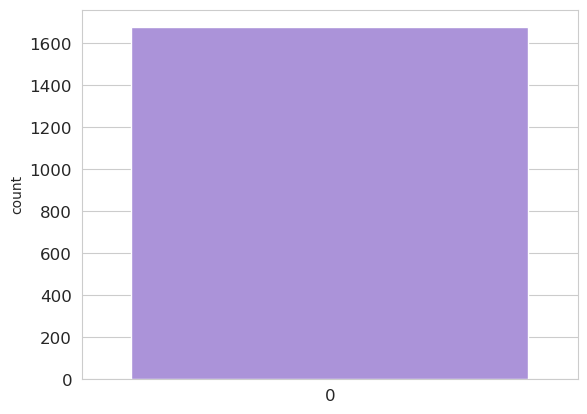

In [8]:
sns.countplot(train["Attrition"], color=custom_colors[1])

We can see that our data is unbalanced which mean it's a problem so we have to be care with this kind of problem.

<AxesSubplot:>

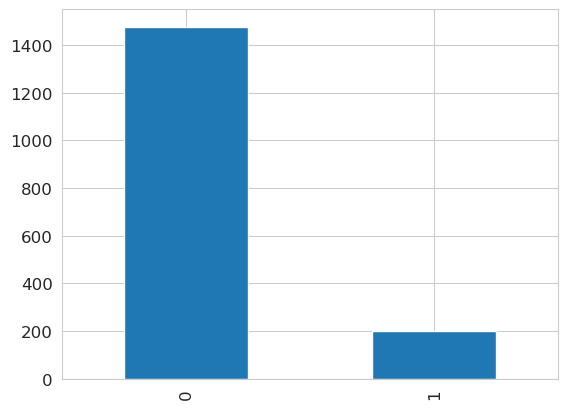

In [9]:
train["Attrition"].value_counts().plot(kind="bar")

In [10]:
# selecting categorical features
cat_features = [
    f for f in train.columns if f not in train.select_dtypes(include=["float", "int"])
]

In [11]:
cat_features

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

 Now it's time to LabelEncode categorical features

In [12]:
for col in cat_features:
    # initialize Label encoder for each features
    le = LabelEncoder()
    # fit transform label encoder on all data
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])
train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,1,599,1,24,3,3,1,4,1,42,3,1,2,4,1,2596,5099,1,0,1,13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,2,921,2,8,3,4,1,1,1,46,3,1,8,1,1,2899,10778,1,0,0,17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,2,718,2,26,3,2,1,3,1,80,3,2,7,4,0,4627,16495,0,0,0,17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,2,1488,1,2,3,3,1,3,0,40,3,2,0,1,1,5347,13384,3,0,0,14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,2,1017,1,5,4,3,1,2,0,37,3,5,3,1,2,19033,19805,1,0,1,13,3,3,80,0,31,0,3,31,14,4,10,1


In [13]:
test.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,19,0,992,1,1,1,3,1,4,1,43,3,1,2,3,2,2318,17778,1,0,0,12,3,4,80,0,1,2,2,1,0,0,0
1,45,2,1136,2,4,4,2,1,3,1,67,3,2,7,1,0,5486,12421,6,0,1,12,3,3,80,1,7,3,3,2,2,2,2
2,37,2,155,1,13,3,1,1,4,1,41,3,1,6,4,0,2741,23577,4,0,1,13,3,2,80,2,13,2,2,7,7,1,7
3,32,2,688,1,1,4,1,1,3,1,89,2,2,0,3,2,5228,20364,1,0,0,13,3,3,80,0,14,2,2,14,10,11,8
4,29,1,464,1,9,1,1,1,3,1,79,3,1,2,4,2,1223,15178,1,0,0,14,3,1,80,0,1,5,3,1,0,0,0


Now we have transform categorical variables to numerical using label encoder so the next thing we are going to do is to select our X and Y variable and then build a model.

In [14]:
X = train.drop("Attrition", axis=1)
y = train.Attrition

In [15]:
X.shape, test.shape

((1677, 33), (1119, 33))

# Modeling

In [16]:
params = {
    "objective": "binary",
    "n_estimators": 30000,
    "max_depth": 10,
    "learning_rate": 0.01,
    "min_child_weight": 256,
    "min_child_samples": 15,
    "reg_alpha": 10,
    "reg_lambda": 0.1,
    "subsample": 0.6,
    "subsample_freq": 1,
    "colsample_bytree": 0.4,
}

In [21]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # model = LGBMClassifier()
    model = CatBoostClassifier()

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        # early_stopping_rounds=400,
    )

    pred_valid = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_valid, pred_valid)
    score = metrics.auc(fpr, tpr)
    scores.append(score)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0
    )

    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print("||" * 40, "\n")

    test_preds = model.predict_proba(test)[:, 1]
    preds.append(test_preds)

print(f"Overall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 0.7949324324324325

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 2 Score: 0.7820945945945947

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 3 Score: 0.8449324324324324

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 4 Score: 0.9097972972972974

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 5 Score: 0.8162162162162162

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 6 Score: 0.8199324324324324

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 7 Score: 0.8293918918918919

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 8 Score: 0.8238095238095238

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 9 Score: 0.9350340136054421

|||||||||||||||||||||

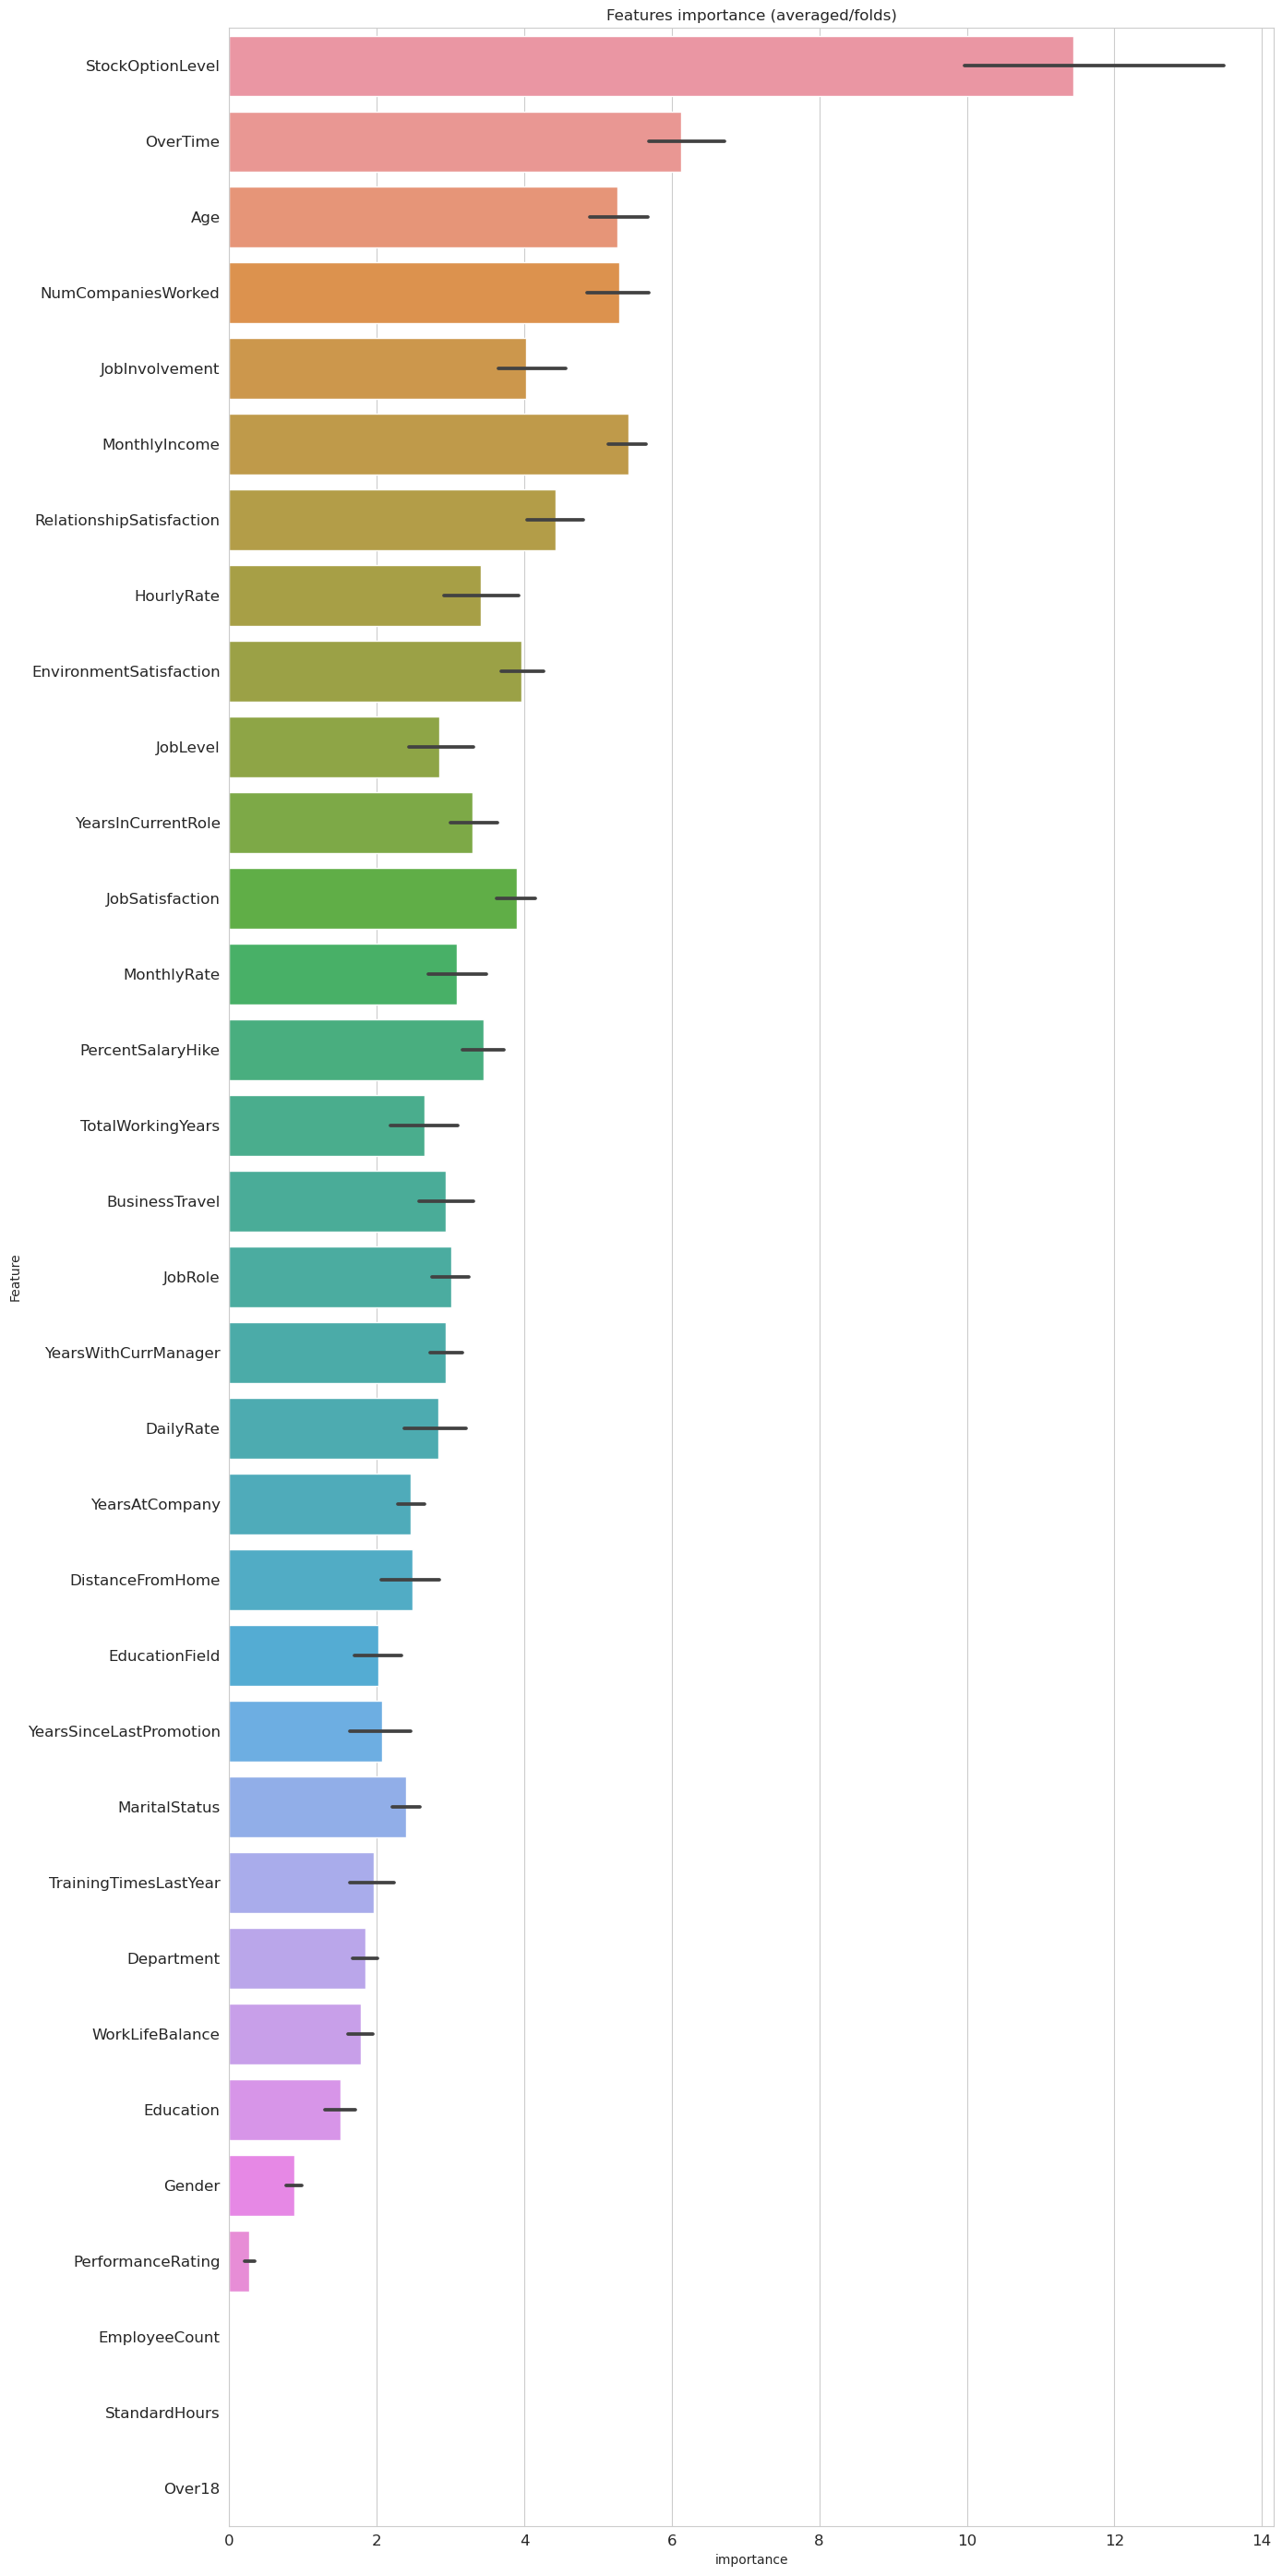

In [22]:
cols = (
    feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:107]
    .index
)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14, 28))
sns.barplot(
    x="importance",
    y="Feature",
    data=best_features.sort_values(by="importance", ascending=False),
)
plt.title("Features importance (averaged/folds)")
plt.tight_layout()
plt.savefig("FI.png")

In [23]:
ss.head()

,id,Attrition
0,1677,0.232501
1,1678,0.052094
2,1679,0.035080
3,1680,0.055672
4,1681,0.413615


In [24]:
predictions = np.mean(np.column_stack(preds), axis=1)

ss["Attrition"] = predictions
ss.to_csv("./cb.csv", index=False)
ss.head()

,id,Attrition
0,1677,0.232501
1,1678,0.052094
2,1679,0.035080
3,1680,0.055672
4,1681,0.413615


In [28]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


def objective(trial, data=X, target=y):

    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=0.2, random_state=42
    )
    param = {
        "metric": "rmse",
        "random_state": 48,
        "n_estimators": 20000,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.006, 0.008, 0.01, 0.014, 0.017, 0.02]
        ),
        "max_depth": trial.suggest_categorical("max_depth", [4, 6, 7, 10, 20, 100]),
        "num_leaves": trial.suggest_int("num_leaves", 1, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("min_data_per_groups", 1, 100),
    }
    cb = CatBoostClassifier(**param)

    cb.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    preds = cb.predict_proba(test_x)

    rmse = roc_auc_score(test_y, preds)

    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2023-01-17 13:10:55,671] A new study created in memory with name: no-name-c35d86b7-b1c7-4fdb-b585-8103d40ca450
[W 2023-01-17 13:10:55,693] Trial 0 failed because of the following error: TypeError("__init__() got an unexpected keyword argument 'metric'")
Traceback (most recent call last):
  File "/home/balde/miniconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_14283/3720580492.py", line 31, in objective
    cb = CatBoostClassifier(**param)
TypeError: __init__() got an unexpected keyword argument 'metric'
